In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn.functional as F
from sklearn.model_selection import KFold, train_test_split
from torch.optim.lr_scheduler import StepLR
import optuna
import warnings
import copy
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def set_seed(seed=42):
    """
    Sets seeds and forces deterministic algorithms.
    """
    print(f"--- Setting Global Seed: {seed} ---")
    
    # 1. Set Env Var for Deterministic Algorithms (Must be before torch usage)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    
    # 2. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # 4. Force Deterministic Algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # New in PyTorch 1.8+ - throws error if an operation is non-deterministic
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except AttributeError:
        pass # Older pytorch versions

In [4]:
def data_segmentation(df, y_label, window_size = 100, stride = 50):
    '''
    Segments the data into the same length and detach the whole dataset into X and y.
    
    df: data frame that contains all covariates and response variables
    y_label: the column name of the response variable that we want to predict
    window_size: the length of time included in a single data point
    stride: The interval between two closest segmented data point
    '''
    j = df.columns.get_loc(y_label)
    data = df.to_numpy()
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    
    while start <= n - window_size:
        end = start + window_size - 1
        if data[start][j] == data[end][j] and data[start][0] + 0.01 > data[end][0] and data[start][j]!=0:
            X.append(data[start:(end+1),1:-7])
            y.append(data[start][j])
            start += stride
        else:
            while start + window_size - 1 < n:
                if data[start][j] != data[start+1][j]:
                    break
                start += 1
            start += 1
    return np.asarray(X), np.asarray(y)

In [5]:
def count_parameters(model):
    """Returns the total number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def train_model(model, data_loader, criterion, optimizer, num_epochs, scheduler=None, print_every_n_batches=100):
    """
    Trains the model and prints the parameter count and running loss periodically.
    Accepts an optional scheduler.
    """

    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every_n_batches == 0:
                avg_loss = running_loss / print_every_n_batches
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{i+1}/{len(data_loader)}] | Running Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
                running_loss = 0.0
        if scheduler is not None:
            scheduler.step()

    print("\nFinished Training.")
    return model
def test_model(model, test_loader):
    """
    Tests the trained model and prints the parameter count and final accuracy.
    """
    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.eval()
    model.to(device)
    correct = 0
    total = 0
    y_test = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_test = np.append(y_test, labels.cpu().numpy())
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)


        # Print the evaluation metrics
        print("Accuracy:", f"{accuracy:.4f}")
        print("Precision:", f"{precision:.4f}")
        print("Recall:", f"{recall:.4f}")
        print("F1 Score:", f"{f1:.4f}")
        print(f"\nTest accuracy of model: {accuracy*100:.2f}%")
        cm = confusion_matrix(y_test, y_pred)

        # plot the confusion matrix
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
        plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    return accuracy

In [6]:
class Augmentations:
    @staticmethod
    def reverse(x):
        """
        Reverses time dim.
        Input: (B, C, L)
        """
        return torch.flip(x, dims=[-1])

    @staticmethod
    def permute(x, segments=4):
        """
        Splits time series into segments and shuffles them randomly.
        
        CRITICAL FOR MULTI-SENSOR DATA:
        We shuffle the segments of ALL channels (C) synchronously.
        If we shuffled channel 0 differently from channel 1, we would destroy
        the inter-feature correlations (e.g., the relationship between 
        accelerometer and gyroscope).
        """
        B, C, L = x.shape
        segment_len = L // segments
        effective_len = segment_len * segments
        x_trimmed = x[:, :, :effective_len]
        x_reshaped = x_trimmed.view(B, C, segments, segment_len)
        rand_inds = torch.argsort(torch.rand(B, segments, device=x.device), dim=1)
        expanded_inds = rand_inds.view(B, 1, segments, 1).expand(B, C, segments, segment_len)
        x_permuted = torch.gather(x_reshaped, 2, expanded_inds)
        return x_permuted.reshape(B, C, effective_len)

    @staticmethod
    def time_warp(x, sigma=0.2, num_knots=4):
        """
        Simulates time warping by stretching and squeezing time.
        
        CRITICAL FOR MULTI-SENSOR DATA:
        We generate ONE warp flow per sample and apply it to ALL channels.
        """
        B, C, L = x.shape
        device = x.device
        warped_batch = []
        
        for i in range(B):
            ratio = np.random.uniform(0.5, 1.5)
            new_len = int(L * ratio)
            signal_tensor = x[i].unsqueeze(0) 
            warped = F.interpolate(signal_tensor, size=new_len, mode='linear', align_corners=False)
            if new_len > L:
                start = np.random.randint(0, new_len - L)
                restored = warped[:, :, start:start+L]
            else:
                padding = L - new_len
                restored = F.pad(warped, (0, padding), "constant", 0)
            warped_batch.append(restored.squeeze(0))
            
        return torch.stack(warped_batch)

In [7]:
def generate_ssl_batch(x_batch):
    """
    Returns batch augmented with binary labels for Multi-Task Learning.
    Returns:
        x_aug: (4*B, C, L)
        y_rev: (4*B, 1)
        y_perm: (4*B, 1)
        y_warp: (4*B, 1)
    """
    B, C, L = x_batch.shape
    orig = x_batch.clone()
    rev = Augmentations.reverse(x_batch)
    perm = Augmentations.permute(x_batch)
    warp = Augmentations.time_warp(x_batch)
    
    x_combined = torch.cat([orig, rev, perm, warp], dim=0)
    l_rev = torch.cat([
        torch.zeros(B), # Orig
        torch.ones(B),  # Rev
        torch.zeros(B), # Perm 
        torch.zeros(B)  # Warp 
    ]).unsqueeze(1)
    l_perm = torch.cat([
        torch.zeros(B),
        torch.zeros(B),
        torch.ones(B),  # Perm
        torch.zeros(B)
    ]).unsqueeze(1)
    l_warp = torch.cat([
        torch.zeros(B),
        torch.zeros(B),
        torch.zeros(B),
        torch.ones(B)   # Warp
    ]).unsqueeze(1)
    idx = torch.randperm(x_combined.size(0))
    return x_combined[idx], l_rev[idx], l_perm[idx], l_warp[idx]

In [8]:
df_S1 = pd.read_csv("S1.csv")
df_S2 = pd.read_csv("S2.csv")
df_S3 = pd.read_csv("S3.csv")
df_S4 = pd.read_csv("S4.csv")
X1_test, y1_test = data_segmentation(df_S1, "HL_Activity")
X2_test, y2_test = data_segmentation(df_S2, "HL_Activity")
X3_test, y3_test = data_segmentation(df_S3, "HL_Activity")
X4_test, y4_test = data_segmentation(df_S4, "HL_Activity")
y1_test -= 101
y2_test -= 101
y3_test -= 101
y4_test -= 101

In [37]:
X1_test = torch.tensor(X1_test).float()
X2_test = torch.tensor(X2_test).float()
X3_test = torch.tensor(X3_test).float()
X4_test = torch.tensor(X4_test).float()
y1_test = torch.tensor(y1_test).long()
y2_test = torch.tensor(y2_test).long()
y3_test = torch.tensor(y3_test).long()
y4_test = torch.tensor(y4_test).long()
X = torch.cat((X1_test, X2_test, X3_test, X4_test), dim = 0)
y = torch.cat((y1_test, y2_test, y3_test, y4_test), dim = 0)

C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\1173063394.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1_test = torch.tensor(X1_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\1173063394.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X2_test = torch.tensor(X2_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\1173063394.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X3_test = torch.tensor(X3_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\1173063394.py:4: UserWarnin

In [9]:
class BasicBlock1D(nn.Module):
    """
    Standard ResNet Basic Block adapted for 1D.
    Structure: Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN -> Add -> ReLU
    """
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        # If dimensions change (stride > 1 or in != out), we need a 1x1 projection
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_dim=128):
        super(MLPHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1) 
        )
        
    def forward(self, x):
        return self.net(x)

class ResNet_SSL(nn.Module):
    """
    A lightweight ResNet-8 (3 Stages, 1 block each).
    Total layers = Stem + 3*2 (blocks) + FC = ~8 layers
    Max Channels = 128
    """
    def __init__(self, in_channels):
        super(ResNet_SSL, self).__init__()
        self.in_planes = 32 # Start smaller
        
        # 1. Stem
        self.initial_bn = nn.BatchNorm1d(in_channels)
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=5, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # 2. Layers (Only 3 layers, 1 block each)
        # Structure: [1, 1, 1]
        self.layer1 = self._make_layer(BasicBlock1D, 32,  blocks=1, stride=1)
        self.layer2 = self._make_layer(BasicBlock1D, 64,  blocks=1, stride=2)
        self.layer3 = self._make_layer(BasicBlock1D, 128, blocks=1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # 3. SSL Heads (Connected to 128 features)
        self.feature_dim = 128
        self.head_reverse = nn.Linear(128, 1)
        self.head_permute = nn.Linear(128, 1)
        self.head_warp    = nn.Linear(128, 1)

    def _make_layer(self, block, planes, blocks, stride):
        layers = []
        # First block handles stride and expansion
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        # Subsequent blocks (if any)
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def get_embedding(self, x):
        x = self.initial_bn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        return torch.flatten(x, 1)

    def forward(self, x):
        features = self.get_embedding(x)
        return self.head_reverse(features), self.head_permute(features), self.head_warp(features)


# ==========================================
# 3. Fine-Tuning Wrapper
# ==========================================

class DownstreamResNet(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=2):
        super(DownstreamResNet, self).__init__()
        self.encoder = pretrained_encoder
        in_features = pretrained_encoder.feature_dim
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        features = self.encoder.get_embedding(x)
        return self.fc(features)

In [10]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# set_seed(503)
# A. Generate Mock Data (High Dimensional)
N_SAMPLES = X.shape[0]
# Important: With 4 downsampling stages (stride 2), signal length reduces by 2^5 = 32 approx.
# Length 128 -> 4. Valid. If length is too small, ResNet crashes.
SEQ_LEN = X.shape[1]
CHANNELS = X.shape[2]



dataset = TensorDataset(X.transpose(1,2), y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# -----------------------------------
# B. SSL Pre-Training (ResNet-18)
# -----------------------------------
print("\n--- Phase 1: Multi-Head SSL Pre-Training (ResNet-18) ---")

ssl_model = ResNet_SSL(in_channels=CHANNELS).to(device)
optimizer = optim.Adam(ssl_model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss() 

EPOCHS_SSL = 0

ssl_model.train()
for epoch in range(EPOCHS_SSL):
    total_loss = 0
    for x_batch, _ in loader:
        x_batch = x_batch.to(device)
        
        aug_x, l_rev, l_perm, l_warp = generate_ssl_batch(x_batch)
        aug_x = aug_x.to(device)
        l_rev, l_perm, l_warp = l_rev.to(device), l_perm.to(device), l_warp.to(device)
        
        pred_rev, pred_perm, pred_warp = ssl_model(aug_x)
        
        loss = (criterion(pred_rev, l_rev.float()) + 
                criterion(pred_perm, l_perm.float()) + 
                criterion(pred_warp, l_warp.float()))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # print(f"Epoch [{epoch+1}/{EPOCHS_SSL}] SSL Loss: {total_loss/len(loader):.4f}")

Using device: cuda

--- Phase 1: Multi-Head SSL Pre-Training (ResNet-18) ---


--- Setting Global Seed: 503 ---

Model Architecture:
DownstreamResNet(
  (encoder): ResNet_SSL(
    (initial_bn): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(124, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock1D(
        (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
    )
    (

C:\Users\yizhou\AppData\Local\Temp\ipykernel_133896\4075048237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_133896\4075048237.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).long()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_133896\4075048237.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_133896\4075048237.py:11: UserWarning

Epoch [1/1] | Batch [100/515] | Running Loss: 1.1591 | LR: 0.000100
Epoch [1/1] | Batch [200/515] | Running Loss: 0.8638 | LR: 0.000100
Epoch [1/1] | Batch [300/515] | Running Loss: 0.7132 | LR: 0.000100
Epoch [1/1] | Batch [400/515] | Running Loss: 0.6674 | LR: 0.000100
Epoch [1/1] | Batch [500/515] | Running Loss: 0.5859 | LR: 0.000100

Finished Training.

Number of model parameters is: 131008
Accuracy: 0.4401
Precision: 0.6250
Recall: 0.4401
F1 Score: 0.3795

Test accuracy of model: 44.01%


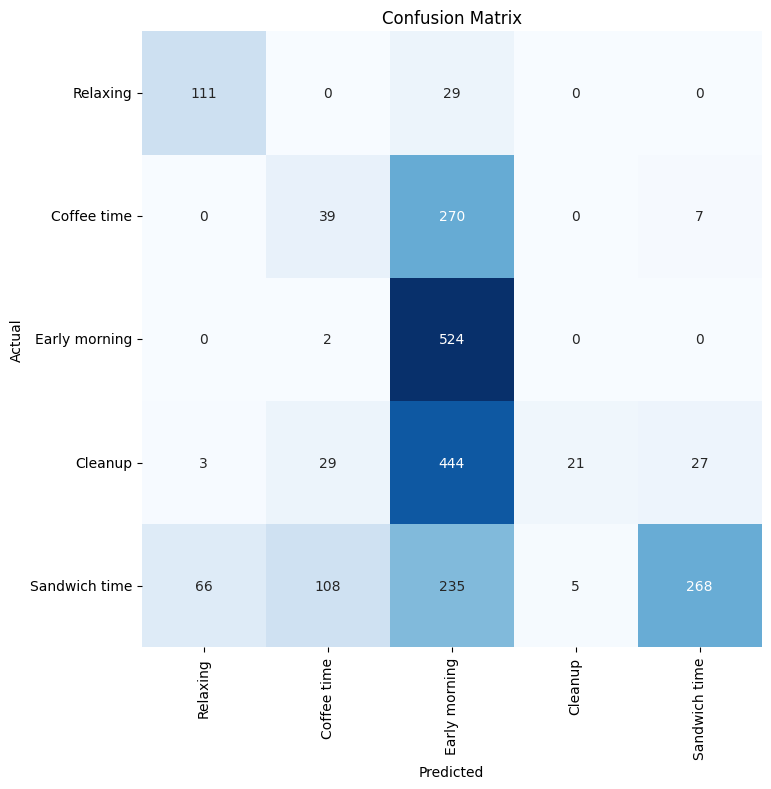

In [ ]:
# set_seed(503)
batch_size = 16
num_epochs = 1
learning_rate = 0.0001
model = DownstreamResNet(ssl_model, num_classes=5).to(device)
optimizer_ft = optim.Adam(model.parameters(), lr=learning_rate)
criterion_ft = nn.CrossEntropyLoss()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
train_dataset = TensorDataset(X_train.transpose(1,2), y_train)
test_dataset = TensorDataset(X_test.transpose(1,2), y_test)
trainloader = torch.utils.data.DataLoader(train_dataset
    , batch_size=batch_size,
    shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(test_dataset
    , batch_size=batch_size,
    shuffle=False, num_workers=4)

# Using Mean Squared Error loss for a regression problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
print("\nModel Architecture:")
print(model)
train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs, scheduler=scheduler)
acc = test_model(model, testloader)

In [11]:

def apply_mask(x, mask_ratio=0.5, patch_size=8):
    """
    Masks blocks of the input time-series.
    x: [Batch, Channels, Time]
    Returns: 
        x_masked: Input with zeros in masked locations
        mask: Binary mask [Batch, 1, Time] (1 = masked, 0 = visible)
    """
    N, C, L = x.shape
    num_patches = L // patch_size
    num_masked = int(num_patches * mask_ratio)
    mask = torch.zeros(N, num_patches, device=x.device)
    noise = torch.rand(N, num_patches, device=x.device)
    _, masked_indices = torch.topk(noise, num_masked, dim=1)
    mask.scatter_(1, masked_indices, 1)
    mask = mask.unsqueeze(1)
    mask = F.interpolate(mask, size=L, mode='nearest')
    x_masked = x * (1 - mask)
    
    return x_masked, mask

# ==========================================
# 2. Basic Components (Your Code + Fixes)
# ==========================================
class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# ==========================================
# 3. The Multi-Task Model
# ==========================================
class MultiTaskResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=6):
        super(MultiTaskResNet, self).__init__()
        self.in_planes = 32 
        
        # --- Shared Encoder (ResNet-8) ---
        self.initial_bn = nn.BatchNorm1d(in_channels)
        # Stem: downsample factor 2 (stride 2) + maxpool factor 2 = total 4? 
        # Note: Your original code had stride 2 in conv1 AND maxpool stride 2.
        # That is extremely aggressive downsampling for short sensor windows.
        # I relaxed conv1 stride to 1 to preserve more temporal info.
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1) # Downsample /2

        self.layer1 = self._make_layer(BasicBlock1D, 32,  blocks=1, stride=1) 
        self.layer2 = self._make_layer(BasicBlock1D, 64,  blocks=1, stride=2) # Downsample /4
        self.layer3 = self._make_layer(BasicBlock1D, 128, blocks=1, stride=2) # Downsample /8

        self.maxxpool = nn.AdaptiveMaxPool1d(1)
        
        # --- Discriminative Heads (Task B: Pretext Classification) ---
        # These use the POOLED features (global context)
        self.head_reverse = nn.Linear(128, 1)
        self.head_permute = nn.Linear(128, 1)
        self.head_warp    = nn.Linear(128, 1)

        # --- Generative Head (Task A: Reconstruction) ---
        # This uses the SPATIAL features (local context)
        # Input: [Batch, 128, L/8] -> Output: [Batch, in_channels, L]
        self.decoder = nn.Sequential(
            # Upsample 1: T/8 -> T/4
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # Upsample 2: T/4 -> T/2
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # Upsample 3: T/2 -> T (Matches maxpool)
            nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # Final Projection to Input Channels
            nn.Conv1d(32, in_channels, kernel_size=3, stride=1, padding=1)
        )

    def _make_layer(self, block, planes, blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward_encoder(self, x):
        """Returns both spatial features (for MAE) and pooled features (for Classif)"""
        x = self.initial_bn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        spatial_feat = self.layer3(x) # [B, 128, T_small]

        pooled_feat = self.maxxpool(spatial_feat) # [B, 128, 1]
        pooled_feat = torch.flatten(pooled_feat, 1) # [B, 128]
        
        return spatial_feat, pooled_feat

    def forward(self, x, task='all', mask_ratio=0.0):
        """
        task: 'all' (pretraining), 'mae_only', 'class_only', or 'downstream'
        """
        if task == 'downstream':
            # Just return features for fine-tuning
            _, pooled = self.forward_encoder(x)
            return pooled

        # 1. MAE Branch
        # Apply mask to input
        x_masked, mask = apply_mask(x, mask_ratio=mask_ratio)
        
        # Encode
        # Important: We pass the MASKED input to the encoder
        spatial, pooled = self.forward_encoder(x_masked)
        
        outputs = {}
        
        # Reconstruction Output
        recon_x = self.decoder(spatial)
        outputs['recon'] = recon_x
        outputs['mask'] = mask # Needed for loss calculation

        # 2. Classification Branch
        # In a real loop, you might feed different batches (x_transformed) here
        # For simplicity, we assume x might be transformed before entering forward
        outputs['reverse'] = self.head_reverse(pooled)
        outputs['permute'] = self.head_permute(pooled)
        outputs['warp'] = self.head_warp(pooled)
        
        return outputs

# ==========================================
# 4. Loss Function Example
# ==========================================
def multitask_loss(outputs, original_x, labels_reverse, labels_permute, labels_warp):
    """
    Combines Reconstruction Loss and Classification Loss
    """
    # 1. MAE Loss (MSE) - Only on masked regions!
    recon = outputs['recon']
    mask = outputs['mask']
    
    # Ensure shapes match (Decoder output might be slightly off due to padding)
    if recon.shape[-1] != original_x.shape[-1]:
        recon = F.interpolate(recon, size=original_x.shape[-1])
        
    # Loss = ||(x - x_hat) * mask||^2
    # We only care about errors where mask == 1
    loss_recon = (original_x - recon) ** 2
    loss_recon = (loss_recon * mask).sum() / (mask.sum() + 1e-8) # Normalize by number of masked pixels

    # 2. Classification Losses (BCE)
    loss_rev = F.binary_cross_entropy_with_logits(outputs['reverse'], labels_reverse)
    loss_perm = F.binary_cross_entropy_with_logits(outputs['permute'], labels_permute)
    loss_warp = F.binary_cross_entropy_with_logits(outputs['warp'], labels_warp)
    
    # Weighted Sum (Tune lambda as needed)
    lambda_mae = 1.0
    lambda_cls = 0.5
    
    total_loss = lambda_mae * loss_recon + lambda_cls * (loss_rev + loss_perm + loss_warp)
    
    return total_loss, loss_recon, (loss_rev+loss_perm+loss_warp)

In [38]:
learning_rate = 0.001
N_SAMPLES = X.shape[0]
SEQ_LEN = X.shape[1]
CHANNELS = X.shape[2]


std_per_channel = torch.std(X.transpose(1,2), dim=2)

sample_weights = std_per_channel.mean(dim=1)

sample_weights = sample_weights + 1e-6

print(f"Max Weight: {sample_weights.max():.4f}, Min Weight: {sample_weights.min():.4f}")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

ssl_model = MultiTaskResNet(in_channels=CHANNELS).to(device)
optimizer = optim.Adam(ssl_model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()
dataset = TensorDataset(X.transpose(1,2), y)
loader = DataLoader(dataset, batch_size=32, sampler = sampler, shuffle=False)
EPOCHS_SSL = 10
weight = [0.0001, 1]
ssl_model.train()
for epoch in range(EPOCHS_SSL):
    total_loss = 0
    total_recon_loss = 0
    total_class_loss = 0
    for x_batch, _ in loader:
        x_batch = x_batch.to(device)
        outputs = ssl_model(x_batch, task = 'mae_only', mask_ratio = 0.5)
        reverse = outputs['reverse']
        permute  = outputs['permute']
        warp = outputs['warp']
        dummy = torch.zeros(x_batch.size(0), device=device).reshape(-1, 1)
        
        _, loss_recon, _ = multitask_loss(outputs, x_batch, dummy, dummy, dummy)
        x_aug, l_rev, l_perm, l_warp = generate_ssl_batch(x_batch)
        outputs_cls = ssl_model(x_aug, task='class_only', mask_ratio=0.0)
        # print(l_rev)
        l_rev = l_rev.to("cuda")
        l_perm = l_perm.to("cuda")
        l_warp = l_warp.to("cuda")
        _, _, loss_class = multitask_loss(outputs_cls, x_aug, l_rev, l_perm, l_warp)
        loss = (weight[0] * loss_recon) + (weight[1] * loss_class)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon_loss += loss_recon.item()
        total_class_loss += loss_class.item()
    avg_loss = total_loss / len(loader)
    avg_recon = total_recon_loss / len(loader)
    avg_class = total_class_loss / len(loader)    
    print(f"Epoch [{epoch+1}/{EPOCHS_SSL}] Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | Class: {avg_class:.4f}")

Max Weight: 2.1150, Min Weight: 0.0074


c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)
c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)`

Epoch [1/10] Total: 0.8134 | Recon: 149.9784 | Class: 0.7984
Epoch [2/10] Total: 0.4464 | Recon: 139.8799 | Class: 0.4324
Epoch [3/10] Total: 0.3640 | Recon: 136.8638 | Class: 0.3503
Epoch [4/10] Total: 0.3099 | Recon: 134.5263 | Class: 0.2965
Epoch [5/10] Total: 0.2791 | Recon: 132.7530 | Class: 0.2659
Epoch [6/10] Total: 0.2638 | Recon: 131.9068 | Class: 0.2506
Epoch [7/10] Total: 0.2402 | Recon: 130.4019 | Class: 0.2271
Epoch [8/10] Total: 0.2230 | Recon: 131.8688 | Class: 0.2098
Epoch [9/10] Total: 0.2101 | Recon: 127.7937 | Class: 0.1973
Epoch [10/10] Total: 0.2032 | Recon: 129.4453 | Class: 0.1902


In [13]:
def test_model(model, test_loader):
    """
    Tests the trained model and prints the parameter count and final accuracy.
    """
    print(f"\nNumber of model parameters is: {count_parameters(model)}")

    model.eval()
    model.to(device)
    correct = 0
    total = 0
    y_test = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_test = np.append(y_test, labels.cpu().numpy())
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [40]:
class DownstreamClassifier(nn.Module):
    """
    Wraps the pre-trained SSL model to perform classification.
    Discards the Decoder and Pretext heads.
    """
    def __init__(self, pretrained_model, num_classes, freeze_encoder=False):
        super(DownstreamClassifier, self).__init__()
        self.encoder = pretrained_model
        # Create a new classification head
        # The encoder outputs 128-dim pooled features
        self.fc = nn.Linear(128, num_classes)
        
        if freeze_encoder:
            self.freeze_encoder_weights()

    def freeze_encoder_weights(self):
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def unfreeze_encoder_weights(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

    def forward(self, x):
        # We only use the 'downstream' task to get pooled features
        features = self.encoder(x, task='downstream')
        logits = self.fc(features)
        return logits

def fine_tune_train(model, loader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_batch.transpose(1,2))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(loader):.4f} | Acc: {100 * correct / total:.2f}%")
seed = [130, 427, 200, 104, 110, 36, 503, 1028, 409, 1130]
if __name__ == "__main__":
    result = np.zeros((20, 4))
    k = 0
    for i in range(4):
        X = [X1_test, X2_test, X3_test, X4_test]
        y = [y1_test, y2_test, y3_test, y4_test]
        X_test = X.pop(i)
        y_test = y.pop(i)
        X_train = torch.concatenate(X, axis = 0)
        y_train = torch.concatenate(y, axis = 0)
        dataset = TensorDataset(X_train, y_train)
        loader = DataLoader(dataset, batch_size=16, shuffle=True)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 2. Load Pre-trained Model
        print("Loading Pre-trained SSL Weights...")
        ssl_model = MultiTaskResNet(in_channels=CHANNELS).to(device)
        initial_state = copy.deepcopy(ssl_model.state_dict())
        # 3. Initialize Fine-Tuning Model
        NUM_CLASSES = 5
        for j in range(5):
            ssl_model.load_state_dict(initial_state)
            set_seed(seed[j])
            model = DownstreamClassifier(ssl_model, NUM_CLASSES, freeze_encoder=True).to(device)
            criterion = nn.CrossEntropyLoss()
            class_counts = torch.bincount(y_train)
            weights = 1. / class_counts.float()
            weights = weights / weights.sum()
            criterion = nn.CrossEntropyLoss(weight=weights.to(device))
            print("\nPhase 1: Linear Probing (Encoder Frozen)")
            optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
            fine_tune_train(model, loader, optimizer_head, criterion, device, epochs=3)
            print("\nPhase 2: Full Fine-Tuning (Encoder Unfrozen)")
            model.unfreeze_encoder_weights()
            optimizer_all = optim.Adam([
                {'params': model.encoder.parameters(), 'lr': 1e-4}, # Low LR
                {'params': model.fc.parameters(),      'lr': 1e-3}  # High LR
            ])
            fine_tune_train(model, loader, optimizer_all, criterion, device, epochs=3)
            X_test = torch.tensor(X_test).float()
            y_test = torch.tensor(y_test).long()
            test_dataset = TensorDataset(X_test.transpose(1,2), y_test)
            testloader = torch.utils.data.DataLoader(test_dataset
                , batch_size=16,
                shuffle=False, num_workers=4)
            accuracy, precision, recall, f1 = test_model(model, testloader)
            result[k, 0] = accuracy
            result[k, 1] = precision
            result[k, 2] = recall
            result[k, 3] = f1
            print(accuracy)
            k+=1

Loading Pre-trained SSL Weights...
--- Setting Global Seed: 130 ---

Phase 1: Linear Probing (Encoder Frozen)
Epoch 1/3 | Loss: 1.3247 | Acc: 47.82%
Epoch 2/3 | Loss: 1.1523 | Acc: 55.69%
Epoch 3/3 | Loss: 1.0979 | Acc: 57.43%

Phase 2: Full Fine-Tuning (Encoder Unfrozen)
Epoch 1/3 | Loss: 0.8016 | Acc: 68.31%
Epoch 2/3 | Loss: 0.5816 | Acc: 76.10%
Epoch 3/3 | Loss: 0.4990 | Acc: 79.61%

Number of model parameters is: 189253


C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\2505475813.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\2505475813.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).long()


0.6558732345849122
--- Setting Global Seed: 427 ---

Phase 1: Linear Probing (Encoder Frozen)


c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/3 | Loss: 1.3256 | Acc: 48.14%
Epoch 2/3 | Loss: 1.1635 | Acc: 55.00%
Epoch 3/3 | Loss: 1.1149 | Acc: 56.31%

Phase 2: Full Fine-Tuning (Encoder Unfrozen)


c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:97.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/3 | Loss: 0.8022 | Acc: 67.86%
Epoch 2/3 | Loss: 0.5965 | Acc: 75.28%
Epoch 3/3 | Loss: 0.4959 | Acc: 79.49%

Number of model parameters is: 189253


C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\2505475813.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\yizhou\AppData\Local\Temp\ipykernel_151820\2505475813.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).long()


0.611091973820186
--- Setting Global Seed: 200 ---

Phase 1: Linear Probing (Encoder Frozen)


c:\Users\yizhou\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/3 | Loss: 1.3421 | Acc: 47.57%
Epoch 2/3 | Loss: 1.1419 | Acc: 56.19%


KeyboardInterrupt: 

In [28]:
result

array([[0.67516362, 0.69141506, 0.67516362, 0.67552376],
       [0.62831554, 0.63274176, 0.62831554, 0.62683534],
       [0.64760592, 0.67468794, 0.64760592, 0.64913281],
       [0.63107131, 0.65095831, 0.63107131, 0.62951672],
       [0.60179125, 0.61721082, 0.60179125, 0.60028354],
       [0.67280306, 0.67101782, 0.67280306, 0.66725203],
       [0.66724557, 0.71641588, 0.66724557, 0.67554454],
       [0.67176103, 0.6732993 , 0.67176103, 0.6690899 ],
       [0.62348038, 0.66041742, 0.62348038, 0.62333217],
       [0.67002431, 0.6691605 , 0.67002431, 0.65780479],
       [0.55921856, 0.64853352, 0.55921856, 0.56452608],
       [0.59259259, 0.63590892, 0.59259259, 0.58261039],
       [0.60805861, 0.6208062 , 0.60805861, 0.60098188],
       [0.58974359, 0.63552584, 0.58974359, 0.58547731],
       [0.57102157, 0.66124576, 0.57102157, 0.56856745],
       [0.64031079, 0.64667003, 0.64031079, 0.63508787],
       [0.6179159 , 0.63678087, 0.6179159 , 0.61095958],
       [0.67778793, 0.68604077,

In [ ]:
np.mean(result, axis=0)

array([0.6489262 , 0.66573248, 0.6489262 , 0.64743156])

In [ ]:
from scipy import stats
np.std(result, axis = 0)/np.sqrt(10   )*stats.t.ppf(0.975, df=9)

array([0.01777658, 0.01905431, 0.01777658, 0.01766918])